## Day 21 Lecture 2 Assignment

In this assignment, we will apply techniques for identifying and dealing with outliers to a dataset containing information about Uber rides.

In [40]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings 
from scipy import stats

warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
uber_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/uber_rides.csv')

In [18]:
uber_data.info()
uber_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   trip_uid           678 non-null    object 
 1   trip_time          678 non-null    object 
 2   total_time         678 non-null    object 
 3   wait_time          678 non-null    object 
 4   price_rub          678 non-null    object 
 5   price_usd          678 non-null    float64
 6   distance_kms       678 non-null    float64
 7   temperature_value  678 non-null    int64  
 8   feels_like         678 non-null    int64  
 9   humidity           678 non-null    float64
 10  wind_speed         678 non-null    float64
 11  cloudness          678 non-null    object 
dtypes: float64(4), int64(2), object(6)
memory usage: 63.7+ KB


,trip_uid,trip_time,total_time,wait_time,price_rub,price_usd,distance_kms,temperature_value,feels_like,humidity,wind_speed,cloudness
0,ee89076fd9da9bddf5f096b0ca42f8d5,0:21:33,0:29:00,0:07:27,265,5.17,9.29,12,12,0.69,4.81,0.78
1,518be51d403944a03c47e8d1f2c87311,0:19:27,0:26:00,0:06:33,255,4.97,9.93,10,10,0.70,6.53,0.66
2,6e460cc8a12c3c6568d0d4a67ac58393,1:06:53,1:23:00,0:16:07,644,13.01,18.01,14,14,0.61,5.25,0.86
3,49613a86a04e6c15d72b51d1a2935d81,0:13:37,0:20:00,0:06:23,1287,25.99,5.10,3,3,0.84,0.87,0.56
4,9896148fdecdb4c5d977a8691510bdb6,0:38:54,0:49:00,0:10:06,665,13.43,21.92,3,1,0.90,1.61,0.31


Before we identify outliers in the given columns, we need to address three time columns (trip_time, total_time, and wait_time), which are provided as formatted strings (HH:MM:SS) instead of numeric values. Convert the values in these three columns into their numeric equivalents in minutes - "2:15" should be converted to "2.25", "1:22:30" should be converted to "82.5", and so on. You may find it helpful to write a function that does this and use the .apply() function to apply it to all of the necessary columns.

In [20]:
# answer goes here
def convert_to_minutes(df):
  return round(pd.to_timedelta(df).seconds/60, 2)

for time_col in [col for col in uber_data.columns if 'time' in col]:
  # uber_data[time_col] = pd.to_timedelta(uber_data[time_col]).dt.seconds.div(60).round(2)
  uber_data[time_col] = uber_data[time_col].apply(convert_to_minutes)

uber_data.head()

,trip_uid,trip_time,total_time,wait_time,price_rub,price_usd,distance_kms,temperature_value,feels_like,humidity,wind_speed,cloudness
0,ee89076fd9da9bddf5f096b0ca42f8d5,21.55,29.0,7.45,265,5.17,9.29,12,12,0.69,4.81,0.78
1,518be51d403944a03c47e8d1f2c87311,19.45,26.0,6.55,255,4.97,9.93,10,10,0.70,6.53,0.66
2,6e460cc8a12c3c6568d0d4a67ac58393,66.88,83.0,16.12,644,13.01,18.01,14,14,0.61,5.25,0.86
3,49613a86a04e6c15d72b51d1a2935d81,13.62,20.0,6.38,1287,25.99,5.10,3,3,0.84,0.87,0.56
4,9896148fdecdb4c5d977a8691510bdb6,38.90,49.0,10.10,665,13.43,21.92,3,1,0.90,1.61,0.31


Plot histograms for each of the column, excluding the trip ID. Which features appear to have outliers? What do you suspect the nature of these outliers is (i.e. do you think these are most likely data errors, or correct values that are simply unusually large or small?)

In [21]:
for column in [col for col in uber_data.columns if col != 'trip_uid']:
  print('These are the problematic values for the column: {}'.format(column))
  for value in uber_data[column]:
    try:
      float(value)
    except:
      print(value)

These are the problematic values for the column: trip_time
These are the problematic values for the column: total_time
These are the problematic values for the column: wait_time
These are the problematic values for the column: price_rub
1,800.00
1,800.00
These are the problematic values for the column: price_usd
These are the problematic values for the column: distance_kms
These are the problematic values for the column: temperature_value
These are the problematic values for the column: feels_like
These are the problematic values for the column: humidity
These are the problematic values for the column: wind_speed
These are the problematic values for the column: cloudness
Node Not Available


In [27]:
uber_data['price_rub'] = uber_data['price_rub'].apply(str.strip).replace('1,800.00', '1800.00')
uber_data['cloudness'] = uber_data['cloudness'].apply(str.strip).replace('Node Not Available', np.nan)

In [28]:
for column in [col for col in uber_data.columns if col != 'trip_uid']:
  print('These are the problematic values for the column: {}'.format(column))
  for value in uber_data[column]:
    try:
      float(value)
    except:
      print(value)

These are the problematic values for the column: trip_time
These are the problematic values for the column: total_time
These are the problematic values for the column: wait_time
These are the problematic values for the column: price_rub
These are the problematic values for the column: price_usd
These are the problematic values for the column: distance_kms
These are the problematic values for the column: temperature_value
These are the problematic values for the column: feels_like
These are the problematic values for the column: humidity
These are the problematic values for the column: wind_speed
These are the problematic values for the column: cloudness


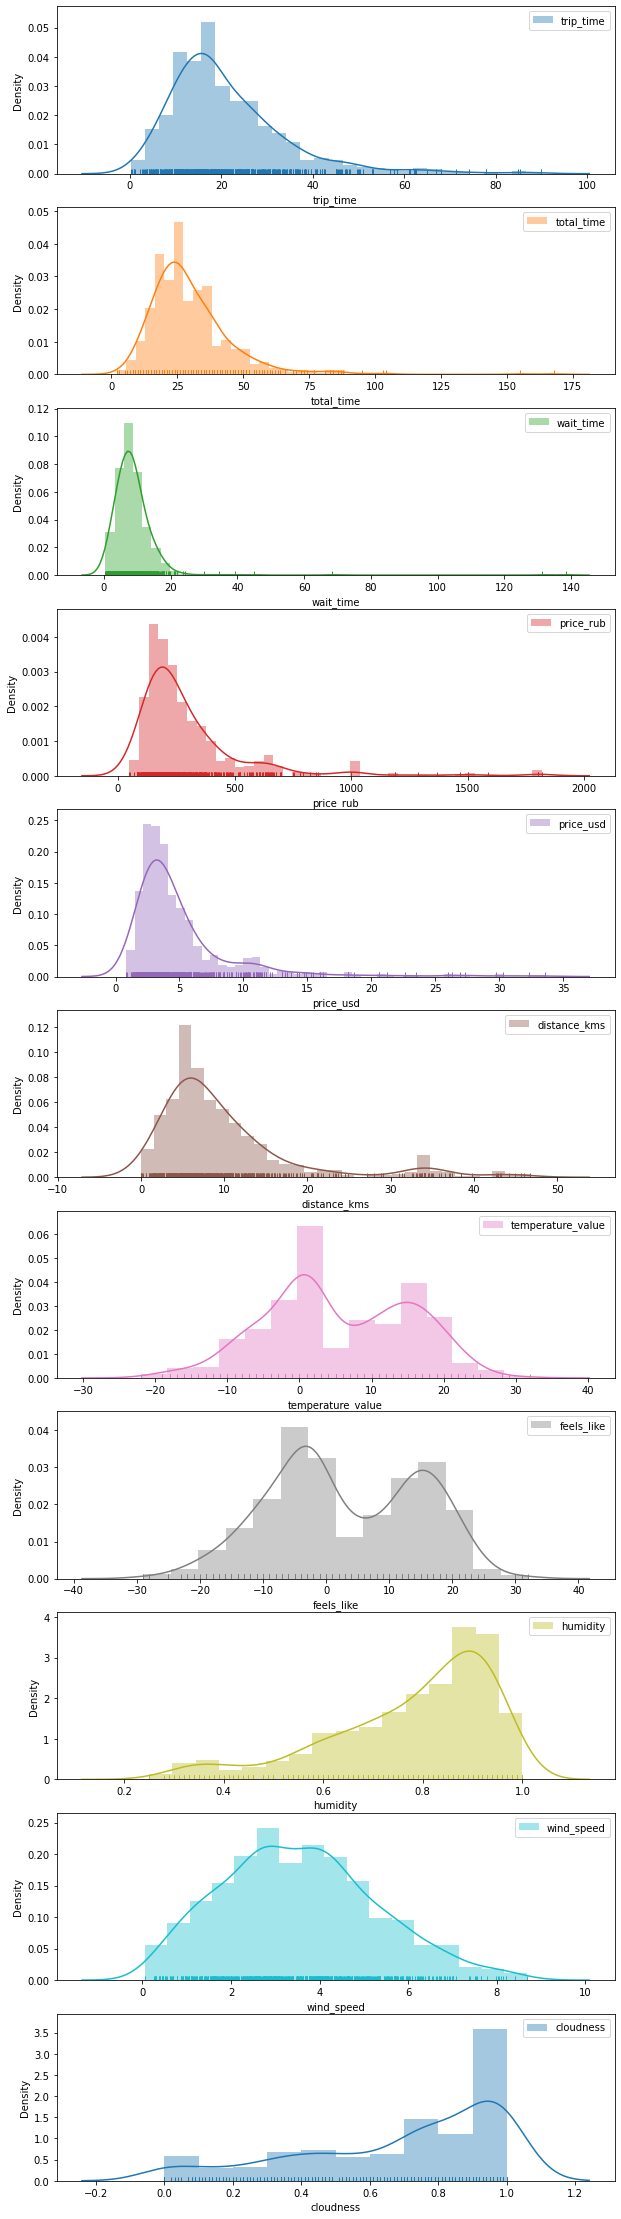

In [34]:
# answer goes here
colors = plt.rcParams["axes.prop_cycle"]()
rows = len(uber_data.columns)-1
fig, axes = plt.subplots(rows, 1, figsize=(10,40))
row = 0

for col in [col for col in uber_data.columns if col != 'trip_uid']:
  c = next(colors)['color']
  sns.distplot(uber_data[col].astype(float), rug=True, color=c, ax=axes[row], label='{}'.format(col))
  axes[row].legend()
  row += 1

plt.show()

The wait_time and price_rub appear to have outliers. The `1,800.00` values in price_rub are likely due to error, as it includes a comma. 

Many of the other plots have a larger positive skew that could be considered as outliers, but there is likely a correlation between the variables for these apparent values (i.e., high distance means higher price and time values).


Using Tukey's IQR method and a threshold value of 1.5, how many trips have trip_time values that are identified as outliers? Print these trips out.

In [36]:
# answer goes here
q75, q25 = np.percentile(uber_data['trip_time'], [75,25])

iqr = q75 - q25

threshold = 1.5

min_val = q25 - (iqr*threshold)
max_val = q75 + (iqr*threshold)
print('The score threshold is: {}'.format(threshold))
print('The number of outliers is: {}'.format(
    len((np.where((uber_data['trip_time'] > max_val) |
                  (uber_data['trip_time'] < min_val))[0]))
))

The score threshold is: 1.5
The number of outliers is: 30


In [39]:
uber_data[['trip_uid', 'trip_time']].loc[(uber_data['trip_time'] >= max_val) | (uber_data['trip_time'] <= min_val)]

,trip_uid,trip_time
2,6e460cc8a12c3c6568d0d4a67ac58393,66.88
13,36695e9088a840d3f7476e86294aa846,50.22
29,72801dd197d168a38ebaa88875492d60,68.07
45,f981dcaa5c7120490cdd38357b78c79c,48.22
47,e4004a6b46e6e1556f76f63f295a3f37,62.02
79,51785bfdf539132f5304a7ae1e1a6d9e,53.22
106,176e430aa7aafb4472cb09677d05fc2b,51.05
108,22f1e9c384f584cf65c51555e5428703,85.32
117,ab98f8918dff094689ae1657dadb6bbd,71.20
201,5383e6be5bc4f5edc74d2a22a422e30f,47.97


There are various ways of handling outliers, including "clipping" (also called "winsorizing"). Clip the outliers to the appropriate upper/lower threshold calculated as part of Tukey's method. Plot the histogram for trip_time after clipping; how does it look different?

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(youtube_df['Video views'])
plt.title('Hist of video views')

plt.subplot(1,2,2)
plt.hist(np.log(youtube_df['Video views']))
plt.title('Hist of log trans video views')

plt.show()

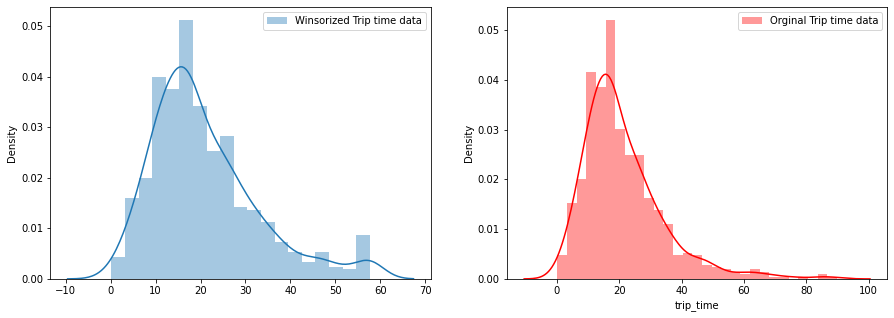

In [57]:
# answer goes here

winsorized_views = stats.mstats.winsorize(uber_data['trip_time'], (0,0.025))

plt.figure(figsize= (15,5))

plt.subplot(1,2,1)
sns.distplot(winsorized_views, label='Winsorized Trip time data')
plt.legend()

plt.subplot(1,2,2)
sns.distplot(uber_data['trip_time'], color='red', label='Orginal Trip time data')
plt.legend()

plt.show()


The winsorized plot is visibly clipped at around ~57.5 and you can clearly see a spike there. 